In [2]:
import tensorflow as tf  # Import TensorFlow library for deep learning tasks
import matplotlib.image as img  # Import matplotlib for image reading
import numpy as np  # Import NumPy for numerical operations
from collections import defaultdict  # Import defaultdict for creating dictionaries with default values
import collections  # Import collections module for collection data types
from shutil import copy  # Import shutil for high-level file operations
from shutil import copytree, rmtree  # Import shutil for directory copying and removal
import tensorflow.keras.backend as K  # Import Keras backend functions
from tensorflow.keras.models import load_model  # Import Keras function for loading pre-trained models
from tensorflow.keras.preprocessing import image  # Import Keras for image preprocessing
import matplotlib.pyplot as plt  # Import matplotlib for visualization
import os  # Import os module for operating system functions
import random  # Import random module for generating random numbers
import cv2  # Import OpenCV for image processing
from tensorflow.keras import regularizers  # Import regularizers for regularization techniques
from tensorflow.keras.applications.inception_v3 import InceptionV3  # Import pre-trained InceptionV3 model
from tensorflow.keras.models import Sequential, Model  # Import Sequential and Model for building neural network models
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten  # Import layers for building neural network architectures
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D  # Import layers for building convolutional neural networks
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Import ImageDataGenerator for data augmentation
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger  # Import callbacks for model saving and logging
from tensorflow.keras.optimizers import SGD  # Import SGD optimizer for training models
from tensorflow.keras.regularizers import l2  # Import L2 regularization
from tensorflow import keras  # Import Keras for deep learning tasks
from tensorflow.keras import models  # Import Keras for building neural network models
import zipfile
import os

In [3]:
# Check TensorFlow version
print(tf.__version__)

# Check GPU device name
print(tf.test.gpu_device_name())

2.15.0
/device:GPU:0


In [5]:
import zipfile

# Unzip the dataset
with zipfile.ZipFile("/content/food-101.zip", 'r') as zip_ref:
    zip_ref.extractall("food")

In [6]:
# Check the extracted dataset folder
!ls /content/food/

food-101  food-101.zip


In [7]:
os.listdir('/content/food/food-101/__MACOSX/food-101/images')

['cheesecake',
 '._ravioli',
 '._edamame',
 '._club_sandwich',
 '._huevos_rancheros',
 'paella',
 '._pizza',
 '._filet_mignon',
 '._sushi',
 '._miso_soup',
 '._gyoza',
 '._crab_cakes',
 'edamame',
 'lobster_roll_sandwich',
 'filet_mignon',
 '._chocolate_mousse',
 'pizza',
 'tacos',
 '._samosa',
 '._grilled_cheese_sandwich',
 '._oysters',
 'pancakes',
 '._onion_rings',
 '._caprese_salad',
 'dumplings',
 '._paella',
 '._fried_rice',
 'hamburger',
 '._bread_pudding',
 '._tuna_tartare',
 'cup_cakes',
 '._pad_thai',
 'spaghetti_carbonara',
 '._waffles',
 '._baklava',
 '._ice_cream',
 '._red_velvet_cake',
 '._omelette',
 'croque_madame',
 '._eggs_benedict',
 '._guacamole',
 '._lobster_roll_sandwich',
 'lasagna',
 '._spaghetti_carbonara',
 'greek_salad',
 'beignets',
 'frozen_yogurt',
 'seaweed_salad',
 'apple_pie',
 '._panna_cotta',
 '._foie_gras',
 '._donuts',
 'fried_rice',
 '._deviled_eggs',
 '._scallops',
 'poutine',
 'chocolate_cake',
 'crab_cakes',
 '._chicken_quesadilla',
 'nachos',
 

In [8]:
os.listdir('/content/food/food-101/__MACOSX/food-101/meta')

['._test.json',
 '._train.txt',
 '._test.txt',
 '._classes.txt',
 '._train.json',
 '._labels.txt']

In [9]:
!head /content/food/food-101/food-101/meta/train.txt
!head /content/food/food-101/food-101/meta/classes.txt

apple_pie/1005649
apple_pie/1014775
apple_pie/1026328
apple_pie/1028787
apple_pie/1043283
apple_pie/1050519
apple_pie/1057749
apple_pie/1057810
apple_pie/1072416
apple_pie/1074856
apple_pie
baby_back_ribs
baklava
beef_carpaccio
beef_tartare
beet_salad
beignets
bibimbap
bread_pudding
breakfast_burrito


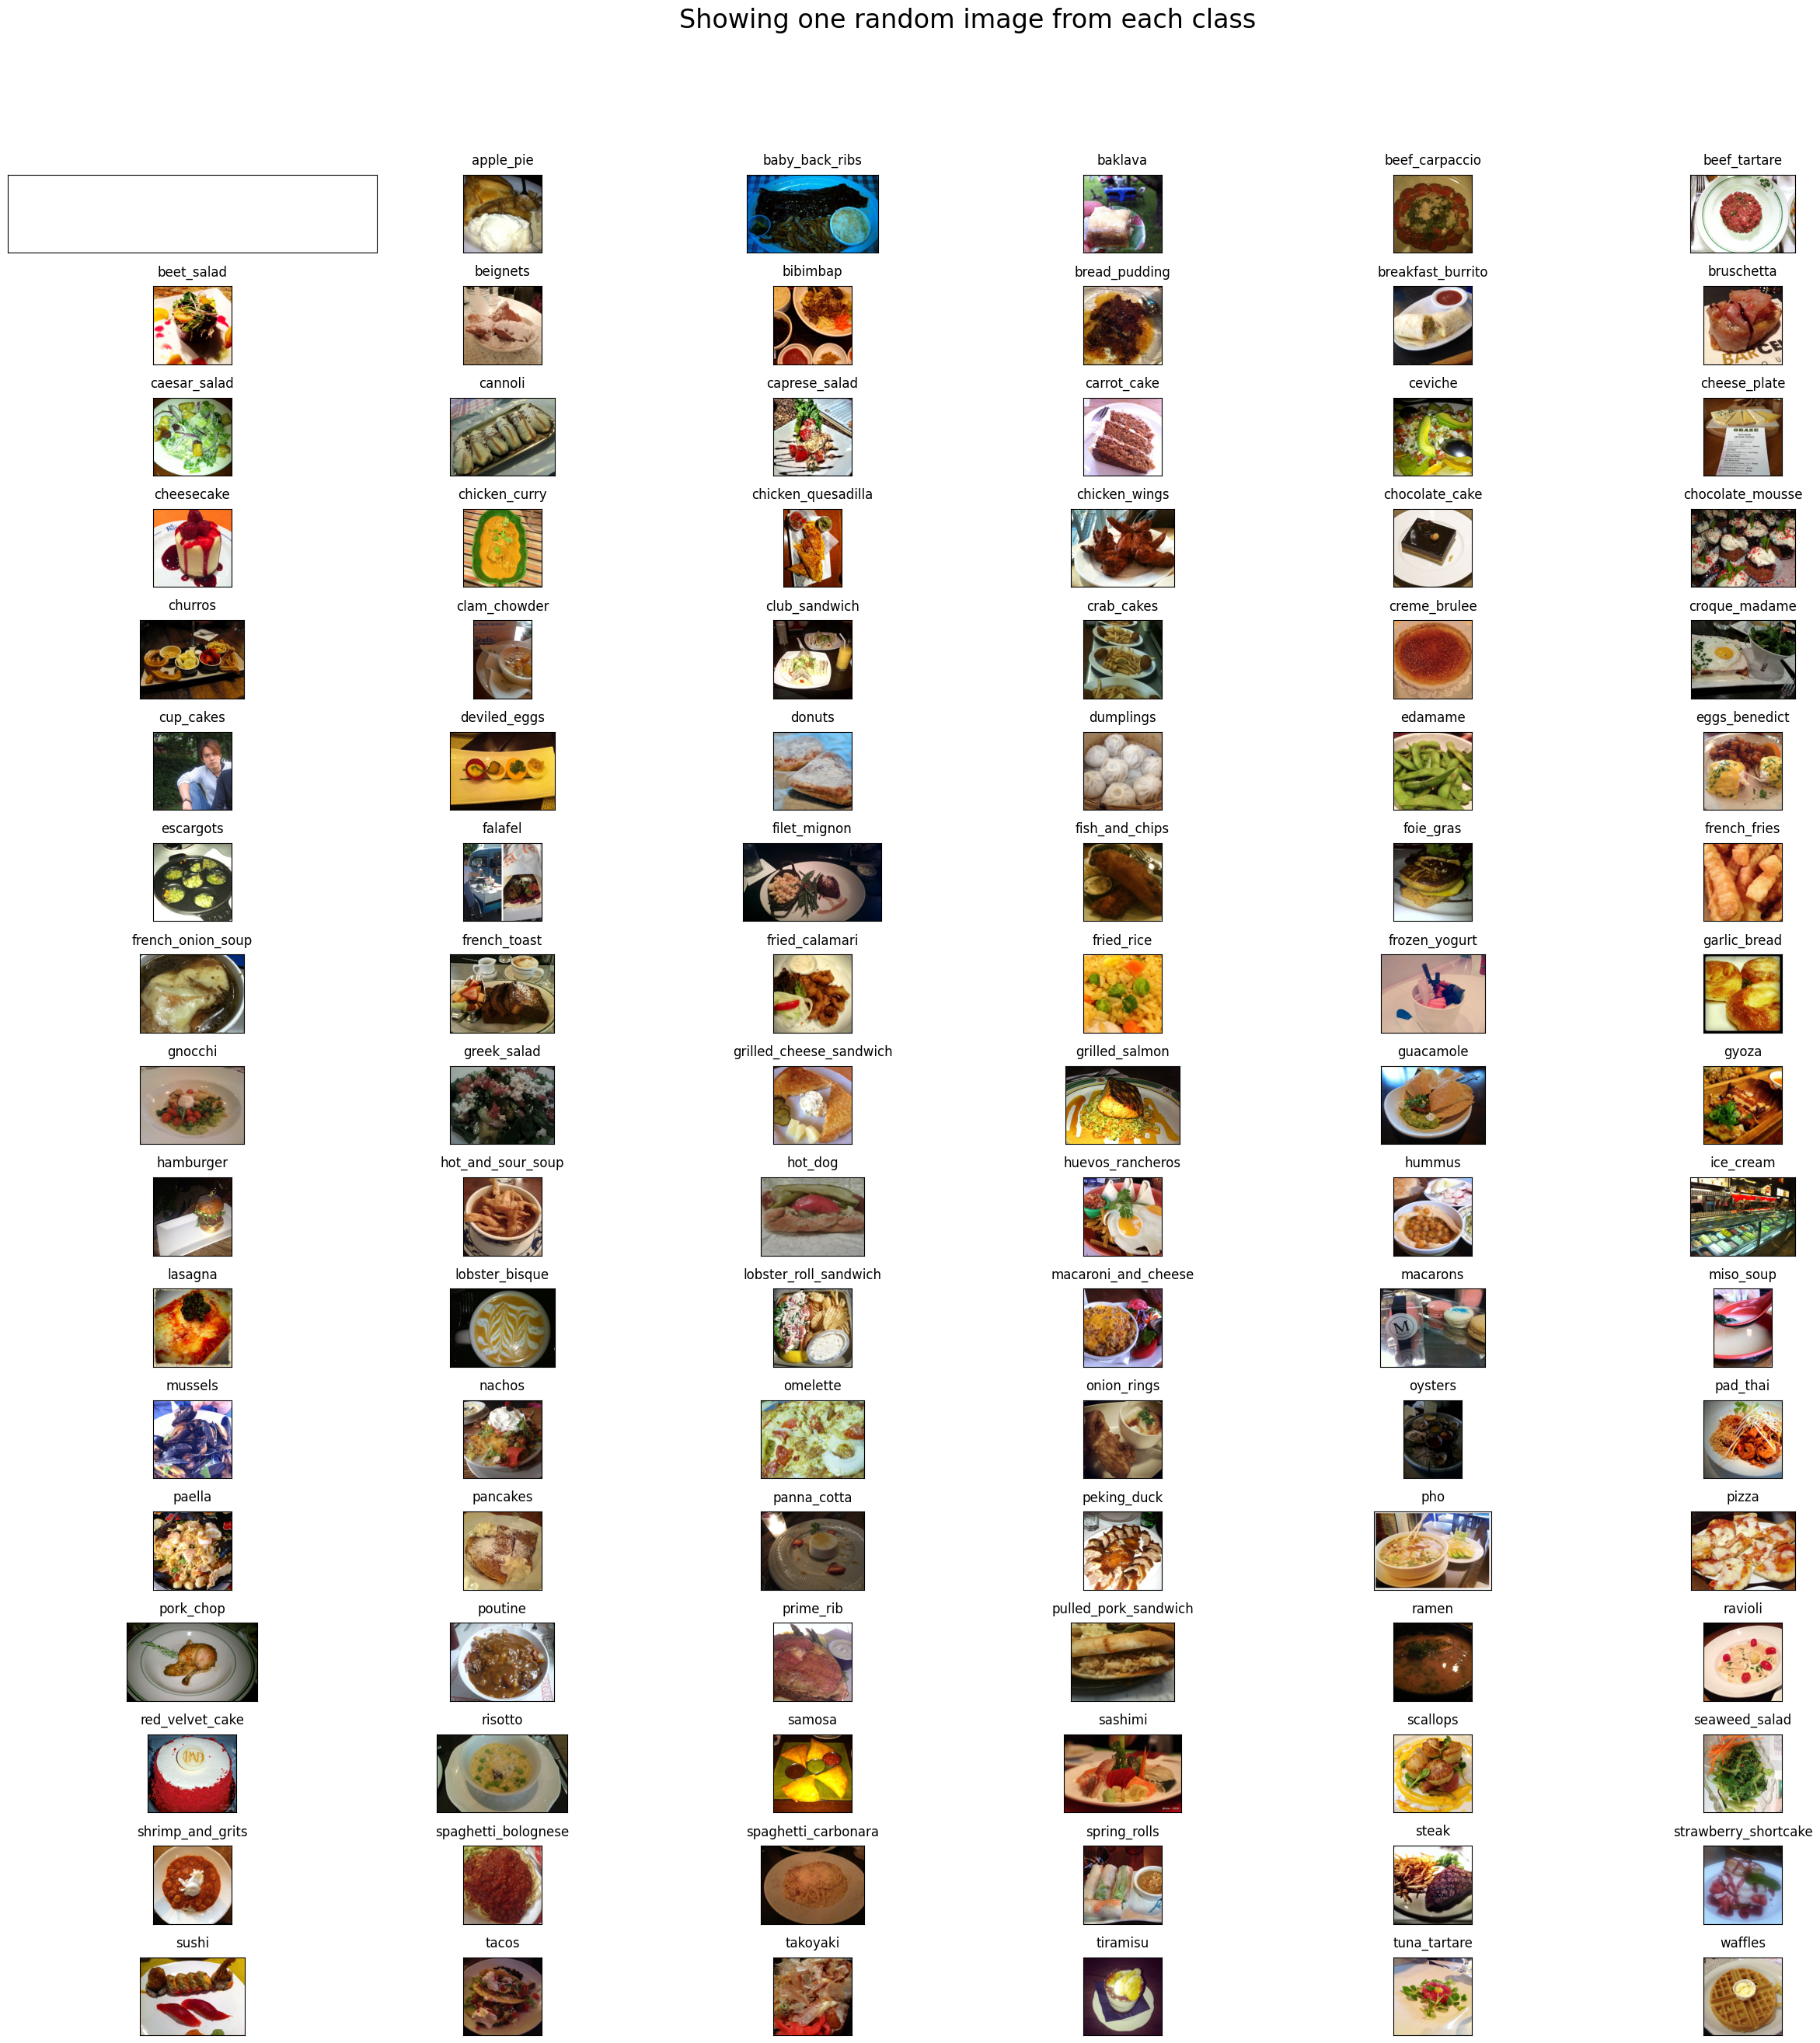

In [10]:
# Define the number of rows and columns for the subplot grid
rows = 17
cols = 6

# Create a subplot grid with specified size
fig, ax = plt.subplots(rows, cols, figsize=(25,25))

# Set the title of the plot
fig.suptitle("Showing one random image from each class", y=1.05, fontsize=24)

# Define the directory containing the image data
data_dir = "/content/food/food-101/food-101/images"

# Get a sorted list of food class names
foods_sorted = sorted(os.listdir(data_dir))

# Initialize food_id variable
food_id = 0

# Loop through rows and columns to display images
for i in range(rows):
    for j in range(cols):
        try:
            food_selected = foods_sorted[food_id]
            food_id += 1
        except:
            break
        if food_selected == '.DS_Store':
            continue
        # Get a list of images for the current food class
        food_selected_images = os.listdir(os.path.join(data_dir, food_selected))
        # Select a random image from the list
        food_selected_random = np.random.choice(food_selected_images)
        # Read and display the image
        img = plt.imread(os.path.join(data_dir, food_selected, food_selected_random))
        ax[i][j].imshow(img)
        ax[i][j].set_title(food_selected, pad=10)  # Set the title of the subplot

# Remove x and y ticks from all subplots
plt.setp(ax, xticks=[], yticks=[])

# Adjust the layout of subplots to fit the figure
plt.tight_layout()

In [11]:
# Helper method to split dataset into train and test folders
def prepare_data(filepath, src, dest):
    # Create a dictionary to store image paths for each class
    classes_images = defaultdict(list)

    # Read the filepath and extract image paths
    with open(filepath, 'r') as txt:
        paths = [read.strip() for read in txt.readlines()]
        for p in paths:
            food = p.split('/')
            classes_images[food[0]].append(food[1] + '.jpg')

    # Iterate over classes and copy images to destination folder
    for food in classes_images.keys():
        print("\nCopying images into ", food)
        if not os.path.exists(os.path.join(dest, food)):
            os.makedirs(os.path.join(dest, food))
        for i in classes_images[food]:
            copy(os.path.join(src, food, i), os.path.join(dest, food, i))
    print("Copying Done!")

In [12]:
# Change current directory to the root directory
%cd /

# Print message indicating the start of creating train data
print("Creating train data...")

# Call prepare_data function to copy images from train.txt to train directory
prepare_data('/content/food/food-101/food-101/meta/train.txt', '/content/food/food-101/food-101/images', 'train')

/
Creating train data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying 

In [13]:
# Print message indicating the start of creating test data
print("Creating test data...")

# Call prepare_data function to copy images from test.txt to test directory
prepare_data('/content/food/food-101/food-101/meta/test.txt', '/content/food/food-101/food-101/images', 'test')

Creating test data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying ima

In [14]:
# Print message indicating the total number of samples in the train folder
print("Total number of samples in train folder")

# Execute the find command to search for files and directories in the train folder
# -type d: Search for directories
# -or: Logical OR operator
# -type f: Search for regular files
# -printf '.': Print a single character for each file or directory found
# wc -c: Count the number of characters (which corresponds to the number of files and directories)
!find train -type d -or -type f -printf '.' | wc -c

Total number of samples in train folder
75750


In [15]:
# Print message indicating the total number of samples in the test folder
print("Total number of samples in test folder")

# Execute the find command to search for files and directories in the test folder
# -type d: Search for directories
# -or: Logical OR operator
# -type f: Search for regular files
# -printf '.': Print a single character for each file or directory found
# wc -c: Count the number of characters (which corresponds to the number of files and directories)
!find test -type d -or -type f -printf '.' | wc -c

Total number of samples in test folder
25250


In [16]:
# List of all 101 types of foods(sorted alphabetically)
del foods_sorted[0] # remove .DS_Store from the list

In [17]:
print(foods_sorted)

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_sou

In [18]:
# Helper method to create train_mini and test_mini data samples
def dataset_mini(food_list, src, dest):
    # Check if the destination directory exists
    if os.path.exists(dest):
        # If it exists, remove it to ensure a clean slate
        rmtree(dest)  # Removing dataset_mini (if it already exists) folders
    # Create the destination directory
    os.makedirs(dest)

    # Iterate over each food item in the provided list
    for food_item in food_list:
        print("Copying images into", food_item)
        # Recursively copy the images from the source directory to the destination directory for each food item
        copytree(os.path.join(src, food_item), os.path.join(dest, food_item))

In [19]:
# List of food items for creating mini datasets
food_list = ['apple_pie', 'pizza', 'omelette']

# Source and destination directories for train and test datasets
src_train = 'train'
dest_train = 'train_mini'
src_test = 'test'
dest_test = 'test_mini'

# Create train_mini dataset
dataset_mini(food_list, src_train, dest_train)

# Create test_mini dataset
dataset_mini(food_list, src_test, dest_test)

Copying images into apple_pie
Copying images into pizza
Copying images into omelette
Copying images into apple_pie
Copying images into pizza
Copying images into omelette


In [20]:
# Print message indicating the creation of the train data folder with new classes
print("Creating train data folder with new classes")

# Create train_mini dataset with specified food classes
dataset_mini(food_list, src_train, dest_train)

Creating train data folder with new classes
Copying images into apple_pie
Copying images into pizza
Copying images into omelette


In [21]:
# Print message indicating the total number of samples in the train folder
print("Total number of samples in train folder")

# Execute the find command to search for files and directories in the train_mini folder
# -type d: Search for directories
# -or: Logical OR operator
# -type f: Search for regular files
# -printf '.': Print a single character for each file or directory found
# wc -c: Count the number of characters (which corresponds to the number of files and directories)
!find train_mini -type d -or -type f -printf '.' | wc -c

Total number of samples in train folder
2250


In [22]:
 #Print message indicating the creation of the test data folder with new classes
print("Creating test data folder with new classes")

# Create test_mini dataset with specified food classes
dataset_mini(food_list, src_test, dest_test)

Creating test data folder with new classes
Copying images into apple_pie
Copying images into pizza
Copying images into omelette


In [23]:
# Print message indicating the total number of samples in the test folder
print("Total number of samples in test folder")

# Execute the find command to search for files and directories in the test_mini folder
# -type d: Search for directories
# -or: Logical OR operator
# -type f: Search for regular files
# -printf '.': Print a single character for each file or directory found
# wc -c: Count the number of characters (which corresponds to the number of files and directories)
!find test_mini -type d -or -type f -printf '.' | wc -c

Total number of samples in test folder
750


In [24]:
# Clear Keras session to release resources
K.clear_session()

# Number of classes in the dataset
n_classes = 3

# Image dimensions
img_width, img_height = 299, 299

# Directories for training and validation data
train_data_dir = 'train_mini'
validation_data_dir = 'test_mini'

# Number of samples in the training and validation sets
nb_train_samples = 2250  # Number of training samples
nb_validation_samples = 750  # Number of validation samples

# Batch size for training
batch_size = 16

# Data augmentation and normalization for training images
train_datagen = ImageDataGenerator(
    rescale=1. / 255,  # Normalize pixel values to the range [0,1]
    shear_range=0.2,   # Shear transformation
    zoom_range=0.2,    # Random zoom
    horizontal_flip=True)  # Horizontal flip

# Normalization for validation images
test_datagen = ImageDataGenerator(rescale=1. / 255)  # Normalize pixel values to the range [0,1]

# Generate batches of training data
train_generator = train_datagen.flow_from_directory(
    train_data_dir,  # Path to the training data directory
    target_size=(img_height, img_width),  # Resize images to match the input size of the model
    batch_size=batch_size,  # Number of samples per batch
    class_mode='categorical')  # Use categorical labels for multi-class classification

# Generate batches of validation data
validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,  # Path to the validation data directory
    target_size=(img_height, img_width),  # Resize images to match the input size of the model
    batch_size=batch_size,  # Number of samples per batch
    class_mode='categorical')  # Use categorical labels for multi-class classification

# Load the pre-trained InceptionV3 model without the top layers
inception = InceptionV3(weights='imagenet', include_top=False)

# Add custom top layers for fine-tuning
x = inception.output  # Output tensor of the InceptionV3 model
x = GlobalAveragePooling2D()(x)  # Global average pooling layer
x = Dense(128, activation='relu')(x)  # Fully connected layer with ReLU activation
x = Dropout(0.2)(x)  # Dropout layer for regularization

# Predictions layer with softmax activation for class probabilities
predictions = Dense(3, kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

# Create the final model with InceptionV3 as the base and custom top layers
model = Model(inputs=inception.input, outputs=predictions)

# Compile the model with SGD optimizer, categorical cross-entropy loss, and accuracy metric
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks for saving the best model and logging training history
checkpointer = ModelCheckpoint(filepath='best_model_3class.hdf5', verbose=1, save_best_only=True)
csv_logger = CSVLogger('history_3class.log')

# Train the model using the training and validation generators
history = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,  # Number of batches per epoch
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,  # Number of validation batches per epoch
    epochs=10,  # Number of training epochs
    verbose=1,  # Verbosity mode (0=silent, 1=progress bar, 2=one line per epoch)
    callbacks=[csv_logger, checkpointer])  # List of callbacks for training

# Save the trained model
model.save('model_trained_3class.hdf5')  # Save the model to HDF5 file format

Found 2250 images belonging to 3 classes.
Found 750 images belonging to 3 classes.
87910968/87910968 [==============================] - 5s 0us/step


<ipython-input-24-518bb8655e2d>:68: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/10
140/140 [==============================] - ETA: 0s - loss: 0.6707 - accuracy: 0.7462
Epoch 1: val_loss improved from inf to 1.69432, saving model to best_model_3class.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


140/140 [==============================] - 103s 513ms/step - loss: 0.6707 - accuracy: 0.7462 - val_loss: 1.6943 - val_accuracy: 0.4674
Epoch 2/10
140/140 [==============================] - ETA: 0s - loss: 0.4627 - accuracy: 0.8344
Epoch 2: val_loss improved from 1.69432 to 0.39942, saving model to best_model_3class.hdf5
140/140 [==============================] - 66s 468ms/step - loss: 0.4627 - accuracy: 0.8344 - val_loss: 0.3994 - val_accuracy: 0.8601
Epoch 3/10
140/140 [==============================] - ETA: 0s - loss: 0.3865 - accuracy: 0.8706
Epoch 3: val_loss did not improve from 0.39942
140/140 [==============================] - 64s 457ms/step - loss: 0.3865 - accuracy: 0.8706 - val_loss: 0.6262 - val_accuracy: 0.7500
Epoch 4/10
140/140 [==============================] - ETA: 0s - loss: 0.3314 - accuracy: 0.8885
Epoch 4: val_loss improved from 0.39942 to 0.37272, saving model to best_model_3class.hdf5
140/140 [==============================] - 63s 447ms/step - loss: 0.3314 - accur

In [25]:
# Get the class indices mapping for the labels in the training data generator
class_map_3 = train_generator.class_indices

# Display the class indices mapping
class_map_3

{'apple_pie': 0, 'omelette': 1, 'pizza': 2}

In [26]:
def plot_accuracy(history, title):
    """
    Plot training and validation accuracy over epochs.

    Args:
    - history: Training history obtained from model training
    - title: Title of the plot

    Returns:
    - None
    """
    plt.title(title)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()

def plot_loss(history, title):
    """
    Plot training and validation loss over epochs.

    Args:
    - history: Training history obtained from model training
    - title: Title of the plot

    Returns:
    - None
    """
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()

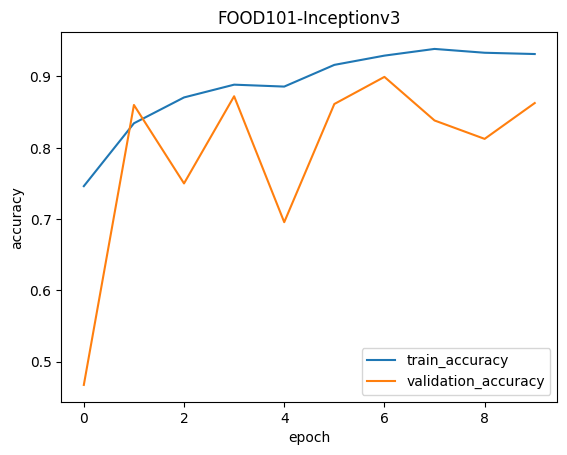

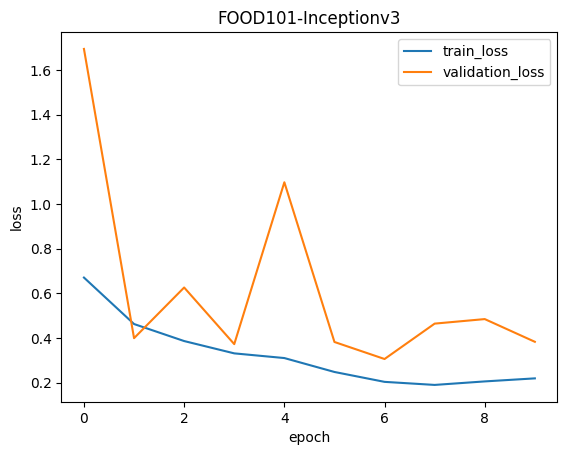

In [27]:
plot_accuracy(history, 'FOOD101-Inceptionv3')  # Plot training and validation accuracy
plot_loss(history, 'FOOD101-Inceptionv3')      # Plot training and validation loss

In [28]:
%%time
# Loading the best saved model to make predictions
K.clear_session()  # Clear Keras session
model_best = load_model('best_model_3class.hdf5', compile=False)  # Load the best saved model

CPU times: user 2.87 s, sys: 134 ms, total: 3.01 s
Wall time: 2.94 s


In [30]:
def predict_class(model, images, show=True):
    """
    Predict the class label for each image in the given list of image paths.

    Args:
    - model: Trained model for making predictions
    - images: List of image paths
    - show: Boolean flag to control image display

    Returns:
    - None
    """
    for img in images:
        img = image.load_img(img, target_size=(299, 299))  # Load image and resize to model's input size
        img = image.img_to_array(img)                     # Convert image to numpy array
        img = np.expand_dims(img, axis=0)                 # Add batch dimension
        img /= 255.                                       # Normalize pixel values

        pred = model.predict(img)                         # Make prediction
        index = np.argmax(pred)                           # Get the index of the class with the highest probability
        food_list.sort()                                  # Sort the list of food items
        pred_value = food_list[index]                     # Get the predicted class label

        if show:
            plt.imshow(img[0])                           # Display the image
            plt.axis('off')
            plt.title(pred_value)                        # Set title as the predicted class label
            plt.show()